In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
np.random.seed(42)
x1 = np.random.rand(100)
x2 = np.random.rand(100)
x3 = np.random.rand(100)
x4 = np.random.rand(100)
noise = np.random.rand(100)
y = x1 + x2**2 + x3*x4

# Create a DataFrame
data = pd.DataFrame({'x1': x1, 'x2': x2, 'x3': x3, 'x4': x4, 'noise': noise, 'y': y})

# Convert the data to torch tensors
X = torch.tensor(data[['x1', 'x2', 'x3', 'x4', 'noise']].values, dtype=torch.float32)
Y = torch.tensor(data['y'].values, dtype=torch.float32).unsqueeze(1)

# Z-score Normalization (mean=0, std=1)
X_mean = X.mean(dim=0, keepdim=True)  # Find the mean of each feature
X_std = X.std(dim=0, keepdim=True)    # Find the standard deviation of each feature
X = (X - X_mean) / X_std  # Standardize each feature

In [3]:
# Define the MLP model
class CustomMLP(nn.Module):
    def __init__(self):
        super(CustomMLP, self).__init__()
        # Prefirst layer (no bias)
        self.linear1 = nn.Linear(1, 1, bias=True)  # for x1
        self.linear2 = nn.Linear(1, 1, bias=True)  # for x2
        self.linear3 = nn.Linear(1, 1, bias=True)  # for x3
        self.linear4 = nn.Linear(1, 1, bias=True)  # for x4
        self.linear5 = nn.Linear(1, 1, bias=True)  # for noise
        
        # MLP layers
        self.fc1 = nn.Linear(5, 16)  # Combine z1 to z5 into MLP
        self.fc2 = nn.Linear(16, 1)

        self.relu = nn.ReLU()

    def forward(self, x):
        # Extract individual features
        x1 = x[:, 0:1]
        x2 = x[:, 1:2]
        x3 = x[:, 2:3]
        x4 = x[:, 3:4]
        noise = x[:, 4:5]

        # Apply prefirst layer transformations
        z1 = self.relu(self.linear1(x1))
        z2 = self.relu(self.linear2(x2))
        z3 = self.relu(self.linear3(x3))
        z4 = self.relu(self.linear4(x4))
        z5 = self.relu(self.linear5(noise))

        # Concatenate z1 to z5
        z = torch.cat([z1, z2, z3, z4, z5], dim=1)

        # MLP layers
        z = self.relu(self.fc1(z))
        output = self.fc2(z)

        return output

In [4]:
# Instantiate the model
model = CustomMLP()

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
def train(model, criterion, optimizer, X, Y, epochs=10000):
    model.train()
    for epoch in range(epochs):
        # Forward pass
        outputs = model(X)
        loss = criterion(outputs, Y)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (epoch+1) % 1000 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.8f}')

# Train the model
train(model, criterion, optimizer, X, Y)

Epoch [1000/10000], Loss: 0.03237724
Epoch [2000/10000], Loss: 0.02834761
Epoch [3000/10000], Loss: 0.02741917
Epoch [4000/10000], Loss: 0.02719337
Epoch [5000/10000], Loss: 0.02637348
Epoch [6000/10000], Loss: 0.02547269
Epoch [7000/10000], Loss: 0.02398791
Epoch [8000/10000], Loss: 0.02365959
Epoch [9000/10000], Loss: 0.02346912
Epoch [10000/10000], Loss: 0.02340605


In [5]:
w1 = model.linear1.weight.item()
w2 = model.linear2.weight.item()
w3 = model.linear3.weight.item()
w4 = model.linear4.weight.item()
w5 = model.linear5.weight.item()

# Create a vector of the parameters
param_vector = torch.tensor([w1, w2, w3, w4, w5]).numpy()

In [6]:
feature_importance = np.abs(param_vector)
feature_importance = feature_importance/np.sum(feature_importance)

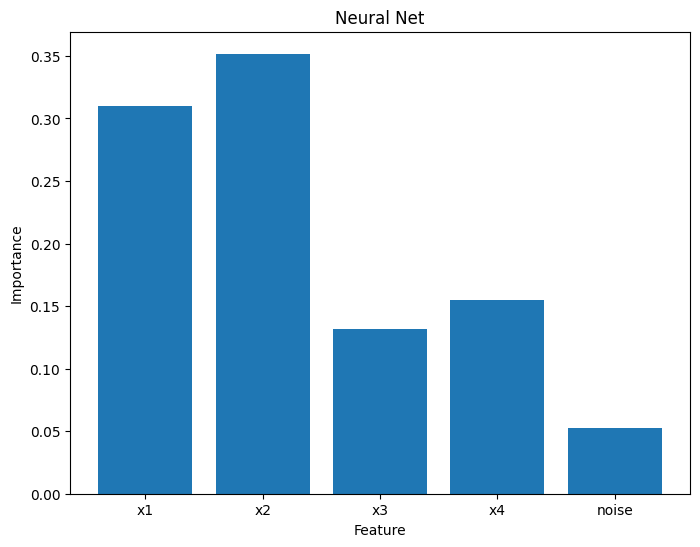

In [7]:
plt.figure(figsize=(8, 6))
plt.bar(data.columns[:-1], feature_importance)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("Neural Net")
plt.savefig("figs/neural_net.png", format='png')
plt.show()